In [13]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load files

In [2]:
train_files = []
mask_files = glob('./data/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

print(train_files[:10])
print(mask_files[:10])

['./data/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10.tif', './data/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_11.tif', './data/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_12.tif', './data/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_13.tif', './data/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_14.tif', './data/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_15.tif', './data/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_16.tif', './data/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_17.tif', './data/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_18.tif', './data/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_19.tif']
['./data/lgg-mri-segmentation/kaggle_3m\\TCGA_CS_4941_19960

# Display sample pics with mask

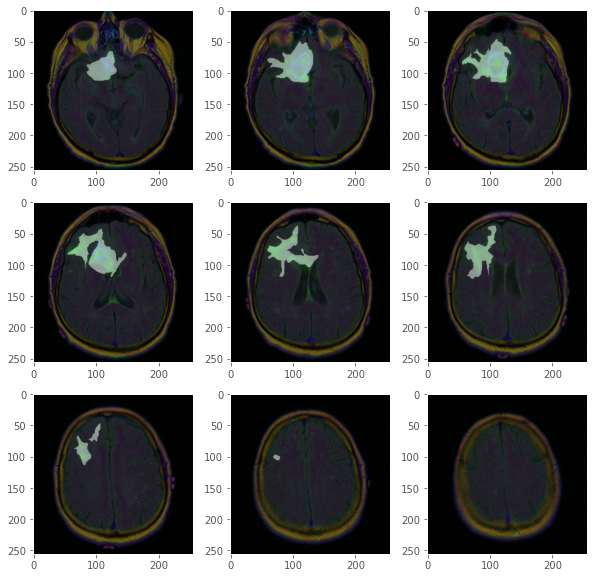

In [3]:
#Lets plot some samples
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_files[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
    plt.grid(False)
plt.show();

# split into train test val

In [4]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.25)
df_train, df_val = train_test_split(df_train,test_size = 0.4)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(1767, 2)
(1179, 2)
(983, 2)


# Loading images

In [5]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

# define metrics and loss functions

In [6]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

# Model design

In [7]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [8]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 64  0           ['conv2d[0][0]']                 
                                )                                                             

# display plots

In [9]:
def plotloss(model):
    a = model.history

    list_traindice = a['dice_coef']
    list_testdice = a['val_dice_coef']

    list_trainjaccard = a['iou']
    list_testjaccard = a['val_iou']

    list_trainloss = a['loss']
    list_testloss = a['val_loss']
    plt.figure(1)
    plt.plot(list_testloss, 'b-')
    plt.plot(list_trainloss,'r-')
    plt.xlabel('iteration')
    plt.ylabel('-Dice')
    plt.title('Loss', fontsize = 15)
    plt.figure(2)
    plt.plot(list_traindice, 'r-')
    plt.plot(list_testdice, 'b-')
    plt.xlabel('iteration')
    plt.ylabel('dice')
    plt.title('Dice scores', fontsize = 15)
    plt.figure(3)
    plt.plot(list_trainjaccard, 'r-')
    plt.plot(list_testjaccard, 'b-')
    plt.xlabel('iteration')
    plt.ylabel('IoU')
    plt.title('Jaccard scores', fontsize = 15)

    plt.show()
    
def plotfigs():
    for i in range(10):
        index=np.random.randint(1,len(df_test.index))
        img = cv2.imread(df_test['filename'].iloc[index])
        img = cv2.resize(img ,(im_height, im_width))
        img = img / 255
        img = img[np.newaxis, :, :, :]
        pred=model.predict(img)

        plt.figure(figsize=(12,12))
        plt.subplot(1,3,1)
        plt.imshow(np.squeeze(img))
        plt.title('Original Image')
        plt.grid(b=None)
        plt.subplot(1,3,2)
        plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])));
        plt.title('Original Mask')
        plt.grid(b=None)
        plt.subplot(1,3,3)
        plt.imshow(np.squeeze(pred) > .5)
        plt.title('Prediction')
        plt.grid(b=None)
        plt.show()

# Model 1: 64x64 for 30epochs

In [14]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

def train_model(image_size=(256,256), n_epochs = 50, model_name='model'):
    BATCH_SIZE = 32
    learning_rate = 1e-4
    
    train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=image_size)
    
    test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=image_size)
    
    test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=image_size)
    
    im_height, im_width = image_size
    
    model = unet(input_size=(im_height, im_width, 3))
    
    decay_rate = learning_rate / n_epochs
    opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
    model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])
    
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', verbose=1, patience=10,min_delta=0.0001, factor=0.2)
    checkpointer = ModelCheckpoint(model_name +'.hdf5', verbose=1, save_best_only=True)
    earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=20)

    callbacks = [reduce_lr, checkpointer, earlystopping]
    
    history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=n_epochs, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) / BATCH_SIZE)
    

    results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
    print("Test loss: ",results[0])
    print("Test IOU: ",results[1])
    print("Test Dice Coefficent: ",results[2])
    
    plotloss(history)        
    plotfigs()

    return

C:\Users\Tau\AppData\Roaming\Python\Python37\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Found 1767 validated image filenames.
Found 1767 validated image filenames.
Epoch 1/50
56/55 [==============================] - ETA: -2s - loss: -0.0642 - binary_accuracy: 0.7869 - iou: 0.0349 - dice_coef: 0.0647Found 1179 validated image filenames.
Found 1179 validated image filenames.

Epoch 00001: val_loss improved from inf to -0.02324, saving model to unet 64.hdf5
55/55 [==============================] - 186s 3s/step - loss: -0.0642 - binary_accuracy: 0.7869 - iou: 0.0349 - dice_coef: 0.0647 - val_loss: -0.0232 - val_binary_accuracy: 0.9901 - val_iou: 0.0126 - val_dice_coef: 0.0233 - lr: 1.0000e-04
Epoch 2/50
56/55 [==============================] - ETA: -2s - loss: -0.1110 - binary_accuracy: 0.9618 - iou: 0.0625 - dice_coef: 0.1127
Epoch 00002: val_loss improved from -0.02324 to -0.02481, saving model to unet 64.hdf5
55/55 [==============================] - 182s 3s/step - loss: -0.1110 - binary_accuracy: 0.9618 - iou: 0.0625 - dice_coef: 0.1127 - val_loss: -0.0248 - val_binary_acc

Epoch 19/50
56/55 [==============================] - ETA: -2s - loss: -0.6050 - binary_accuracy: 0.9961 - iou: 0.4495 - dice_coef: 0.6035
Epoch 00019: val_loss improved from -0.62189 to -0.62487, saving model to unet 64.hdf5
55/55 [==============================] - 175s 3s/step - loss: -0.6050 - binary_accuracy: 0.9961 - iou: 0.4495 - dice_coef: 0.6035 - val_loss: -0.6249 - val_binary_accuracy: 0.9952 - val_iou: 0.4685 - val_dice_coef: 0.6248 - lr: 1.0000e-04
Epoch 20/50
56/55 [==============================] - ETA: -2s - loss: -0.6310 - binary_accuracy: 0.9961 - iou: 0.4782 - dice_coef: 0.6332
Epoch 00020: val_loss did not improve from -0.62487
55/55 [==============================] - 186s 3s/step - loss: -0.6310 - binary_accuracy: 0.9961 - iou: 0.4782 - dice_coef: 0.6332 - val_loss: -0.2962 - val_binary_accuracy: 0.9920 - val_iou: 0.1986 - val_dice_coef: 0.2953 - lr: 1.0000e-04
Epoch 21/50
56/55 [==============================] - ETA: -2s - loss: -0.6535 - binary_accuracy: 0.9964 - i

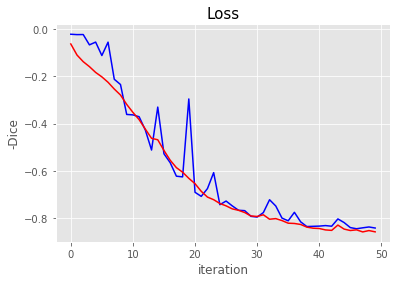

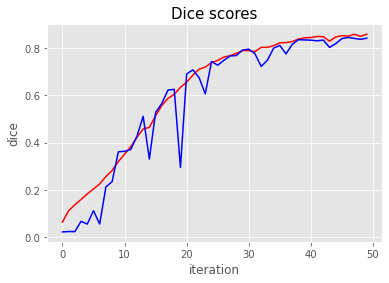

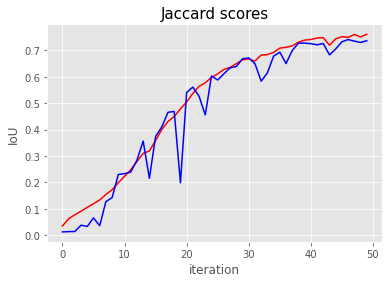

NameError: name 'im_height' is not defined

In [15]:
train_model(image_size=(64, 64), model_name='unet 64')

In [16]:
model = load_model('unet 64.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

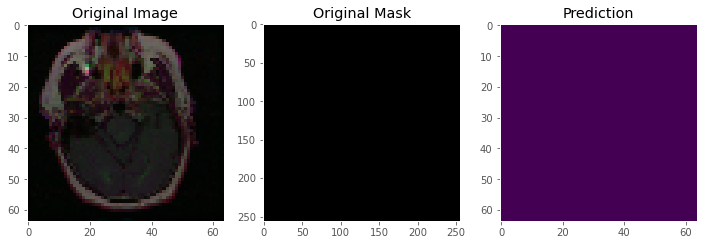

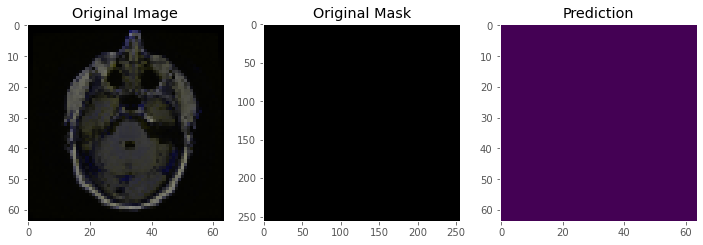

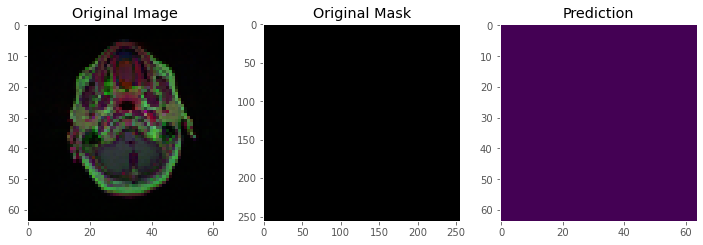

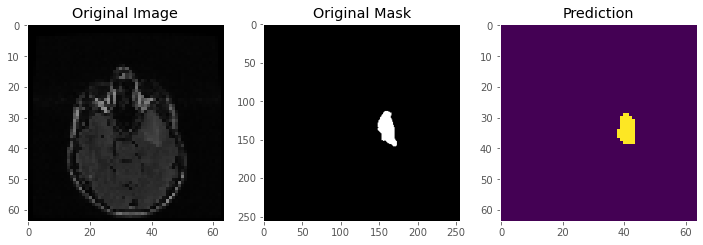

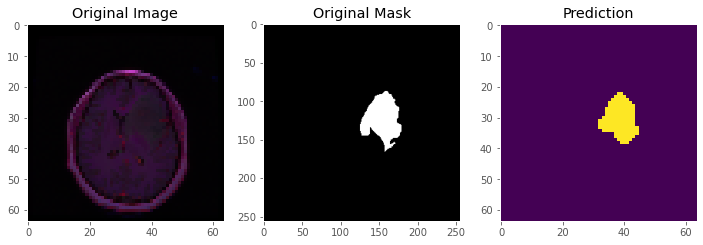

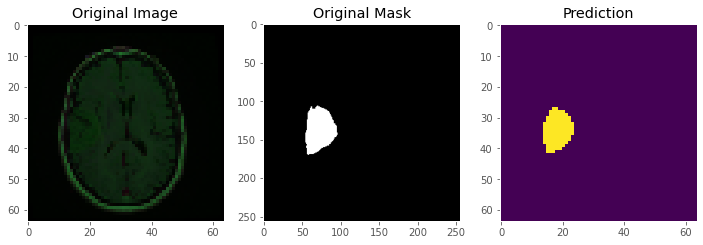

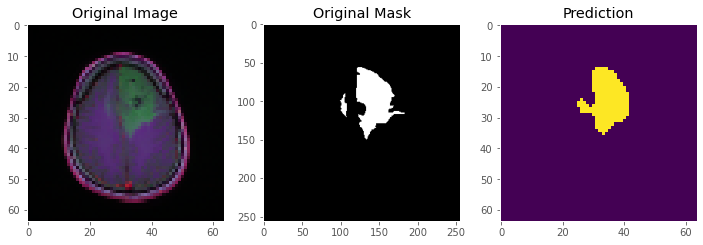

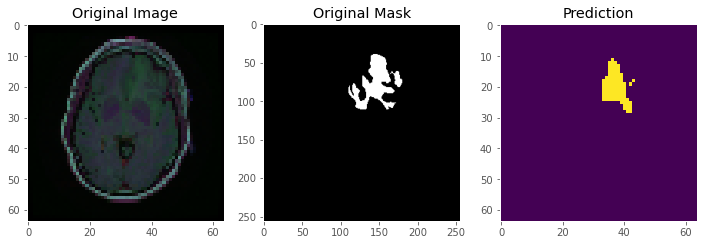

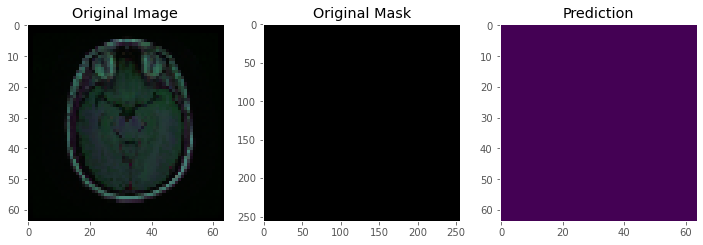

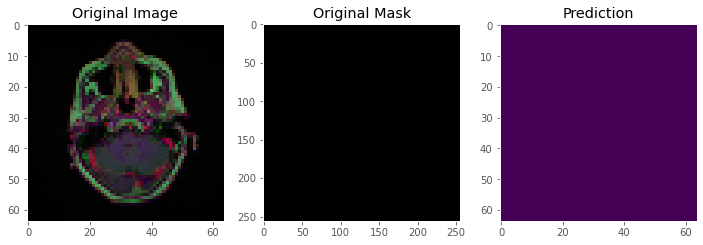

In [19]:
im_height, im_width = (64, 64)
plotfigs()

# Model 2: 128x128 for 30 epochs

In [ ]:
EPOCHS = 30
BATCH_SIZE = 32
learning_rate = 1e-4
im_width = 128
im_height = 128

train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
model2 = unet(input_size=(im_height, im_width, 3))



decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model2.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

callbacks = [ModelCheckpoint('unet_128x128.hdf5', verbose=1, save_best_only=True)]

history2 = model2.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) / BATCH_SIZE)

In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
results = model2.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

In [ ]:
plotloss(history2)
plotfigs();